<a href="https://colab.research.google.com/github/NicoleMeinie/Regression/blob/master/Frankenstein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sendy Logistics Challenge
Logistics is fundamental to the success of many sectors of business.

It is reported that in Africa, logistics add an average of 320% to a manufactured good’s cost. Sendy is a logistics platform currently servicing East Africa and aims to help businesses and enterprises grow through efficient and affordable logistics.

Sendy is trying to predict accurate arrival times that will assist businesses in improving logistic operations by communicating accurate times to customers awaiting deliveries. Data is key in this endeavour and this project aims to use the given data to build a model to predict these arrival times. The Company's focus is "practical solutions for Africa’s dynamic transportation needs, from developing apps and web solutions, to providing dedicated support for goods on the move".


##Mission Objective
The objective of this project is to build a machine learning model that will predict a response variable, 'Time from Pickup to Arrival' (Delivery time) for orders, given an unseen data set. The model will be trained using data containing a number of predictor variables or 'features'.

##Approach
1. Exploratory Data Analysis
2. Feature Selection
3. Feature Engineering
4. Preprocessing
5. Regression Models
6. Model Evaluation
7. Conclusion


***'What a curious plan!'***

# Import Libraries and datasets

In [0]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
%matplotlib inline

# machine learning 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

Three .csv files were provided: "Train.csv", "Test.csv" & "Riders.csv". Let's import these datasets.

In [0]:
# import each csv file
test_raw = pd.read_csv('Test.csv')
train_raw = pd.read_csv('Train.csv')
riders_raw = pd.read_csv('Riders.csv')

# Join riders to test & train data and initialise working dataframes
Train = pd.merge(train_raw, riders_raw, on = "Rider Id", how="left") 
Test = pd.merge(test_raw, riders_raw, how="left", on = "Rider Id")

Great! Let's build a model!

#Exploratory Data Analysis
Hold on! Exploratory Data Analysis (EDA) is vital in determining our data structure, potential patterns and relationships between the variables as well as ascertaining whether our data set is in the best format for processing by the model. We've divided EDA into the following sections: Completeness, Data Types & Relevance and Visualisation. Once we have 'the lay of the land' we'll move on to Feature Engineering and Preprocessing the datasets.

##Completeness of the Data

Quality of a dataset is dependent on completeness. Let's investigate which features have those pesky null values and figure out a way forward to handle them.

In [0]:
train_raw.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [0]:
test_raw.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [0]:
riders_raw.head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


**Observations:**

*  The train data set has four additional columns centred arround the arrival time of the order: 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time', 'Time from Pickup to Arrival'. Other than that the columns are identical. This is expected as if we had these columns present in the Test set, we would not have a response variable to predict!



*  It appears that the riders data could be joined with both the train and test data sets on the column 'Rider Id'. It is anticipated that some variables in this data set such as 'Average Rating' could be influential in predicting the response variable. What's that you say...? "all this does is increase the No. of variables in both sets!"... Yes, but there are definitely some variables that can be removed...

In [0]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [0]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

In [0]:
riders_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rider Id        960 non-null    object 
 1   No_Of_Orders    960 non-null    int64  
 2   Age             960 non-null    int64  
 3   Average_Rating  960 non-null    float64
 4   No_of_Ratings   960 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 37.6+ KB


**Observations:**

*  Both the train & test data sets have missing values for the 'Temperature' & 'Precipitation' columns. The missing values should be imputed using an appropriate method. Approximately 20% of the Temperature values are missing in both the Test & Train data sets. Replacing the NaN with the average would therefore be a reasonable assumption. Approximately 97% of the Precipitation values are missing. Imputation of the NaN values could be achieved either via assuming zero precipitation for those Order times, or imputation by mode.


*  As the data has already been split into train and test sets we can go ahead and impute the values for each set. It is best practice to impute values after the split to prevent data leakage and ensure a fair test of the model.


*  The riders.csv file has no missing values. Phew!


*   There a few object types in each dataframe which need to either be converted into numeric types or potentially dropped from the data set. The time variables are currently object types and also require conversion into DateTime.





*  Summary: impute missing temperature and precipitation values. Join riders to both test & train.

# Cleaning up column names
The column names are a bit messy at the moment.Lets format them nicely before moving on.

In [0]:
#create a function that removes spaces in column names
def col_names_without_spaces(df):
  df.columns = [col.replace(" ","_") for col in df.columns] 
  df.columns = [col.lower() for col in df.columns]
  return df

col_names_without_spaces(Train)
col_names_without_spaces(Test)
Train.head()

,order_no,user_id,vehicle_type,platform_type,personal_or_business,placement_-_day_of_month,placement_-_weekday_(mo_=_1),placement_-_time,confirmation_-_day_of_month,confirmation_-_weekday_(mo_=_1),confirmation_-_time,arrival_at_pickup_-_day_of_month,arrival_at_pickup_-_weekday_(mo_=_1),arrival_at_pickup_-_time,pickup_-_day_of_month,pickup_-_weekday_(mo_=_1),pickup_-_time,arrival_at_destination_-_day_of_month,arrival_at_destination_-_weekday_(mo_=_1),arrival_at_destination_-_time,distance_(km),temperature,precipitation_in_millimeters,pickup_lat,pickup_long,destination_lat,destination_long,rider_id,time_from_pickup_to_arrival,no_of_orders,age,average_rating,no_of_ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


## Data types & Relevance


*Through the looking glass and what the Datanauts found there*

Twenty-Nine variables in the train data set alone! Part of ensuring the quality of a data set to be used in the machine learning model is to ensure that the data recorded is relevant to the objective of the analysis or model.

Let's peer through the looking-glass and inspect each dataset to ascertain which variables could potentially be dropped. We'll pay close attention to any categorical data - specifically 'Order No', 'User Id', 'Vehicle Type', 'Personal or Business', Rider Id and the Various 'Time' data. We'll be using pandas as the primary tool to examine the data.

### Vehicle Type


The only vehicle type included in this data set is 'Bike'. We could leave this in but it really serves no purpose in the model, so we'll drop 'Vehicle Type, with the caveat that this model's predicitive capabilities extend only to deliveries by bike.

In [0]:
print(Train.columns)

Index(['order_no', 'user_id', 'vehicle_type', 'platform_type',
       'personal_or_business', 'placement_-_day_of_month',
       'placement_-_weekday_(mo_=_1)', 'placement_-_time',
       'confirmation_-_day_of_month', 'confirmation_-_weekday_(mo_=_1)',
       'confirmation_-_time', 'arrival_at_pickup_-_day_of_month',
       'arrival_at_pickup_-_weekday_(mo_=_1)', 'arrival_at_pickup_-_time',
       'pickup_-_day_of_month', 'pickup_-_weekday_(mo_=_1)', 'pickup_-_time',
       'arrival_at_destination_-_day_of_month',
       'arrival_at_destination_-_weekday_(mo_=_1)',
       'arrival_at_destination_-_time', 'distance_(km)', 'temperature',
       'precipitation_in_millimeters', 'pickup_lat', 'pickup_long',
       'destination_lat', 'destination_long', 'rider_id',
       'time_from_pickup_to_arrival', 'no_of_orders', 'age', 'average_rating',
       'no_of_ratings'],
      dtype='object')


In [0]:
# Vehicle Type
print(Train['vehicle_type'].value_counts())
print(Test['vehicle_type'].value_counts())

Bike    21201
Name: vehicle_type, dtype: int64
Bike    7068
Name: vehicle_type, dtype: int64


### Identifier Variables


What about the Identifier columns like Riders, Orders & User? As an example, 'Order No' values corresponds to the number of rows in each dataframe. 'Order No' therefore serves as purely an identifier column and would theoretically have no purpose in the model. We do however need the Order No's preserved for the submission data file.

Although there are multiple observations (orders) per rider, Rider_Id can also be dropped as the metrics associated with the rider delivering the order would inlcuded for every data entry after merging 'Riders' with test and train data sets. The same principle applies to User Id, user specific information such as the type of order and user location are included included in the variables 'Personal & Business' and Pickup Latitude and Longitude. 

The 'Personal & Business' category would also need to be 'one hot encoded' to a numeric data type but more about that later. Right! That's all the Id columns taken care of!

In [0]:
# Order No. 
print(str(Train['order_no'].nunique()) + ' unique Order Numbers in train dataset')
print(str(Test['order_no'].nunique()) + ' unique Order Numbers in test dataset')

21201 unique Order Numbers in train dataset
7068 unique Order Numbers in test dataset


###Day, Month & Time Data



Each data entry reports a Day of Month, Weekday & Time for various stages in the Order process accounting for 15 & 12 variables in the train & test datasets respectively.

On Visual inspection it seems as though the Day of Month and Weekday that an Order is Placed, Confirmed, Arrival at Pick up, Pick up, Arrival at Destination is the same i.e Same Day Delivery (Take a bow Sendy!).

Let's confirm that and if that is the case, we only need to retain one column of Day of Month & Weekday per category. We'll Check the first stage (Order Placement) with the last available stage for both Datasets (Arrival at Destination).

In [0]:
print((Train['placement_-_day_of_month'] == Train['pickup_-_day_of_month']).value_counts())

True     21199
False        2
dtype: int64


In [0]:
print((Test['placement_-_day_of_month'] == Test['pickup_-_day_of_month']).value_counts())

True    7068
dtype: int64


With the exception of two entries, we have found that close to 100% of orders have same day delivery. That means that all the information relating to Order Stages before 'Pickup' is redundant.

It also stands to reason that the only possible time related variables worth keeping when measuring a delivery time, are the ones that measure time from the moment the Order is picked up for delivery. In this way the logic to drop these variables is not flawed, even if same day delivery is not possible for an order. We will therefore keep a single 'Day of Month', 'Weekday' and 'Time' column for 'Pickup', which is the stage where the driver leaves for delivering the Order after having collected it from the pickup point. Thats 12 Variables to drop from the train data and 9 from the test data.

##Visualisations

###Distribution of Delivery Times
A histogram of delivery times as well as the outlier threshold will be plotted to visualise the distribution of the delivery times which is our target variable.

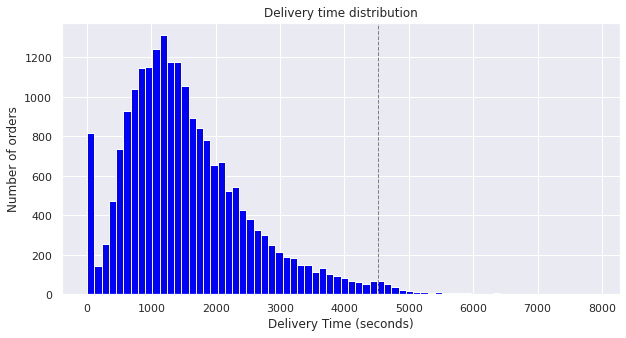

In [0]:
# Calculating the outlier threshold 
mu = Train['time_from_pickup_to_arrival'].mean()
sd = Train['time_from_pickup_to_arrival'].std()
li = mu + 3*sd

# creating the histogram - distribution of delivery times in seconds
sns.set()
_ = plt.figure(figsize = (10,5))
_ = plt.hist(Train['time_from_pickup_to_arrival'], bins = 70, color = 'blue')
_ = plt.title('Delivery time distribution')
_ = plt.xlabel('Delivery Time in seconds')
_ = plt.ylabel('Number of orders')
_ = plt.axvline(li, color = 'gray', linestyle = 'dashed', linewidth = 1)
plt.show()

**Observations:**

*   From the plot above it is clear that the delivery times are positively skewed, with the majority of orders being delivered in approximately 16 minutes. 


*   There are orders with a delivery time of 1 second which is unusual and warrants further investigation.


* The grey dotted line above indicates the threshold for existence of outliers (measured by the presence of values 3 standard deviations away from the mean.) A small portion of the delivery times recorded with times > 4500 seconds could be considered outliers.


### Distribution plots for all the features in the dataset

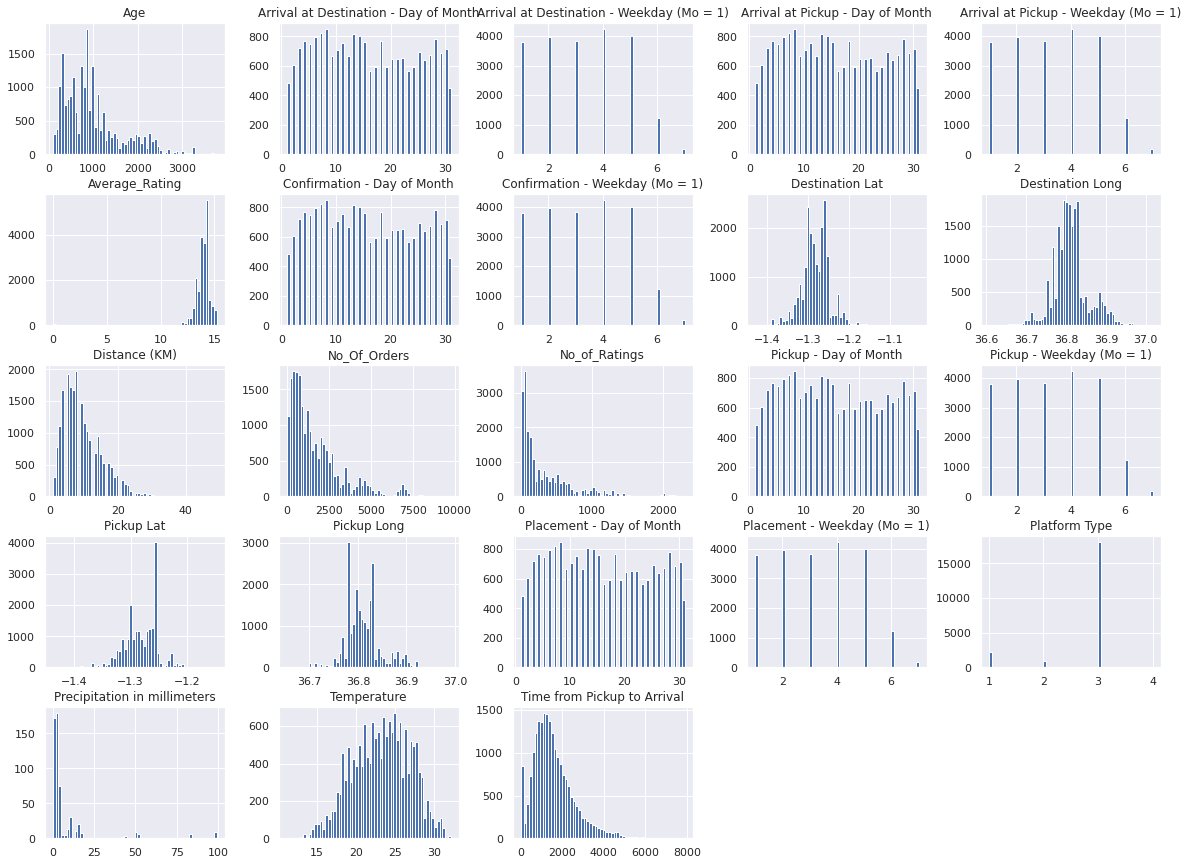

In [0]:
# creating a histogram for all the variables in the dataset to visulize the distribution of each feature
sns.set()
Train.hist(bins = 60, figsize = (20,15))
plt.show()

**Observations:**


*   The majority of orders are placed using Platform 3.
*   Orders and deliveries decline on weekends.
* Most orders are delivered within a 10km radius from the Pickup location.
* Most Temperatures range between 20 and 27 degrees Celsius.
* The average driver rating is between 13 and 15.
* A large proportion of riders have no or very few ratings.

### Exploring the relationship between delivery time and a few features


#### Day of the month
The relationship between the Order placement day of month and the delivery time is visualized using box plots.

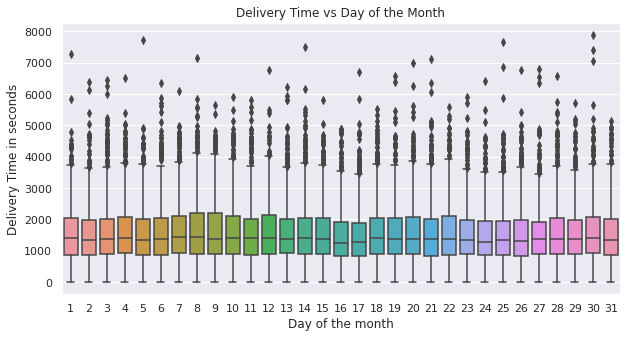

In [0]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['placement_-_day_of_month'], 
                y = Train['time_from_pickup_to_arrival'], 
                data = Train )

_ = plt.title('Delivery Time vs Day of the Month')
_ = plt.xlabel('Day of the month')
_ = plt.ylabel('Delivery Time in seconds')

**Observations:**



*   The delivery times are fairly consistent across the various days of the month, with the median ranging from around 1250-1450 seconds (within 3 minutes). 
*   1 second delivery times are present in each group and there is some variability in maximum values. Outlier delivery times are present on every day of the month and range between 4800 to 7800 seconds (80-130 minutes).



#### Day of the week

The relationship between the day of the week that orders are placed and the delivery times is visualized using a violin plot

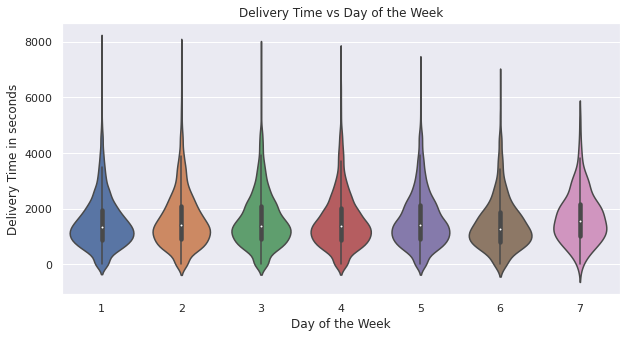

In [0]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.violinplot(x = Train['placement_-_weekday_(mo_=_1)'], 
                   y = Train['time_from_pickup_to_arrival'], 
                   data = Train )

_ = plt.title('Delivery Time vs Day of the Week')
_ = plt.xlabel('Day of the Week')
_ = plt.ylabel('Delivery Time in seconds')

**Observations:**
 

*   Delivery times during the week have the same spread from Monday to Friday with slight differences in the extremity of outliers. 

* The delivery times during weekends have less variability and less extreme outliers. This could possibly be due to drivers experiencing less traffic over weekends. 

#### Type of client
Sendy handles deliveries for businesses and personal clients. Does the type of client serviced have an effect on the delivery time?

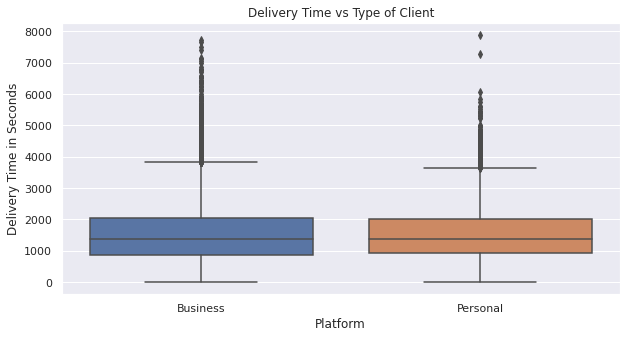

In [0]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['personal_or_business'],
                y = Train['time_from_pickup_to_arrival'], 
                data = Train )

_ = plt.title('Delivery Time vs Type of Client')
_ = plt.xlabel('Platform')
_ = plt.ylabel('Delivery Time in Seconds')

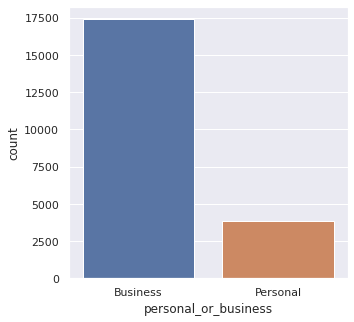

In [0]:
sns.set()
_ = plt.figure(figsize = (5,5))
_ = sns.countplot(x = Train['personal_or_business'], data = Train )

**Observations:**

*  There is almost no difference in the distibution of delivery times for personal clients compared to businesses with the exception of a few outliers.

*   The majority of orders (approximately 80%) comprise Business Orders, alluding to the Sendy client base. Any potential efforts to increase orders could be focused on Personal use clients, or expanding the Business Order client base depending on the Sendy business strategy.




#### Platform used to place orders
Users are able to place orders using 4 different platforms. Is there a relationship between the type of platform used to place an order and the delievry time?

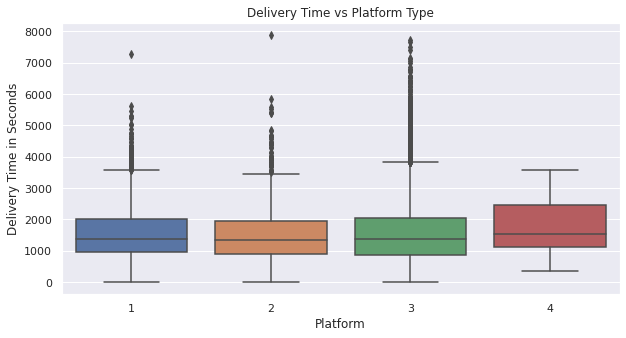

In [0]:
sns.set()
_ = plt.figure(figsize = (10,5))
_ = sns.boxplot(x = Train['platform_type'], 
                y = Train['time_from_pickup_to_arrival'], 
                data = Train )

_ = plt.title('Delivery Time vs Platform Type')
_ = plt.xlabel('Platform')
_ = plt.ylabel('Delivery Time in Seconds')

**Observations:**

*  The delivery times for Platform Type 1 to 3 are similar, although more outliers are observed when orders are placed using Platform 3.

*  The mean and upper quartile for delivery times for orders placed using platform 4 is slightly higher. Remember, from the distribution plots that orders placed using Platform 4 are signicantly less than any other platform which could be the reason for the varying summary statistics (just less observations).

#### Pick up and Drop off areas

The visualisation below displays Delivery times of Orders and their respective Pickup and Destination coordinates. Distance is shown by the size of marker, and delivery time by hue.

Reference: https://plotly.com/python/scattermapbox/

In [0]:
px.scatter_mapbox(Train, 
                     lat='pickup_lat', lon='pickup_long',  
                     color = 'time_from_pickup_to_arrival', 
                     color_continuous_scale = px.colors.cyclical.IceFire,  
                     size = 'distance_(km)',
                     size_max = 15,
                     zoom=9.3, 
                     mapbox_style = 'open-street-map',
                     title = 'Pickup Location')

In [0]:
px.scatter_mapbox(Train, lat='destination_lat', lon='destination_long',  
                     color = 'time_from_pickup_to_arrival', 
                     size = 'distance_(km)',
                     color_continuous_scale = px.colors.cyclical.IceFire,  
                     size_max = 15,
                     zoom=9.3, 
                     mapbox_style = 'open-street-map',
                     title = 'Destination Location')

From the above visualisations above we observe a concentration of Orders with short distances and delivery times within the City of Nairobi. Orders with higher delivery time ranges (orange to red hue) generally have either pickup or destaination coordinates outside of the city and higher distances travelled.

### Checking for Multicolinearity
Visualising the correlation between variables using a heatmap. The predictor variables should be independent in order to determine the true effect on the response variable.

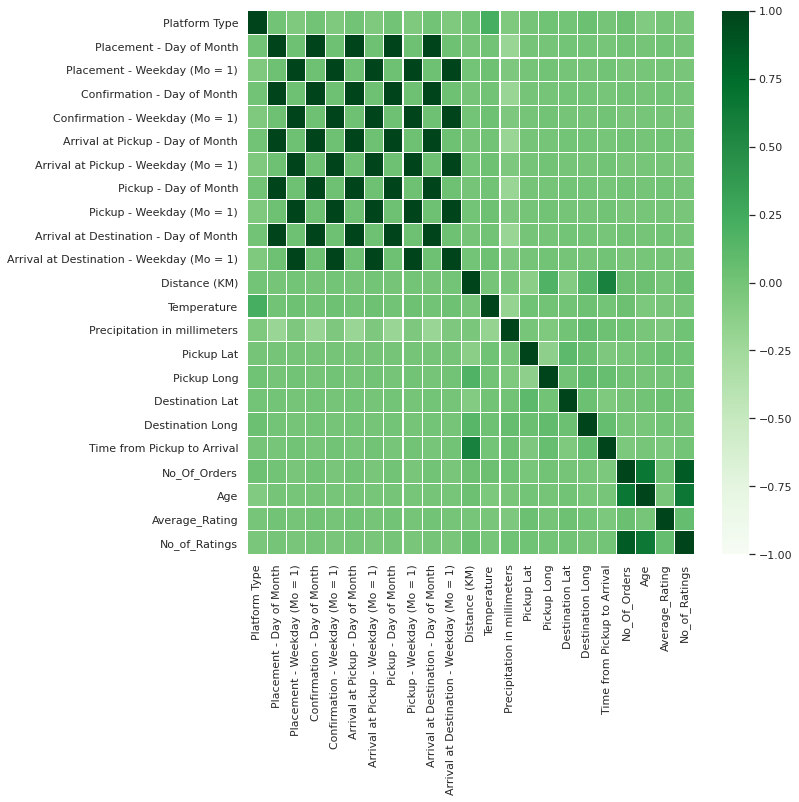

In [0]:
Corr_Matrix = Train.corr()


plt.figure(figsize=(10,10))
sns.heatmap(Corr_Matrix, vmin=-1, vmax=1, cmap= 'Greens', annot= False, linewidth=0.1)


**Observations:**

*   The number of ratings and age columns are highly correlated. From the distribution plots generated earlier it was noted that a large portion of the riders had no or very few ratings as rating of a rider is completely optional for the customer. Keeping this in mind, the number of ratings column could be dropped for the following reasons: it adds less value/useful information compared to the age of the riders and introduces multicolinearity into the dataset.

* Precipitation is slightly correlated to temperature and day of the month

* Another important point to note is the lack of correlation  ( < 0.01) between Delivery time and the following variables:
 - Platform type
 - Temperature
 - Day of the week
 - Age 
 - Number of ratings


In [0]:
Train.columns

Index(['order_no', 'user_id', 'vehicle_type', 'platform_type',
       'personal_or_business', 'placement_-_day_of_month',
       'placement_-_weekday_(mo_=_1)', 'placement_-_time',
       'confirmation_-_day_of_month', 'confirmation_-_weekday_(mo_=_1)',
       'confirmation_-_time', 'arrival_at_pickup_-_day_of_month',
       'arrival_at_pickup_-_weekday_(mo_=_1)', 'arrival_at_pickup_-_time',
       'pickup_-_day_of_month', 'pickup_-_weekday_(mo_=_1)', 'pickup_-_time',
       'arrival_at_destination_-_day_of_month',
       'arrival_at_destination_-_weekday_(mo_=_1)',
       'arrival_at_destination_-_time', 'distance_(km)', 'temperature',
       'precipitation_in_millimeters', 'pickup_lat', 'pickup_long',
       'destination_lat', 'destination_long', 'rider_id',
       'time_from_pickup_to_arrival', 'no_of_orders', 'age', 'average_rating',
       'no_of_ratings'],
      dtype='object')

# Feature Selection



In [0]:
# List of all the column names that should be dropped from the train and test data
to_drop = ['order_no', 
           'user_id', 
           'vehicle_type', 
           'rider_id', 
           'confirmation_-_day_of_month', 
           'confirmation_-_weekday_(mo_=_1)', 
           'confirmation_-_time', 
           'arrival_at_pickup_-_day_of_month', 
           'arrival_at_pickup_-_weekday_(mo_=_1)', 
           'arrival_at_pickup_-_time', 
           'pickup_-_day_of_month', 
           'pickup_-_weekday_(mo_=_1)',]

# columns that should be dropped from the train data only
x_drop = ['arrival_at_destination_-_time', 
          'arrival_at_destination_-_weekday_(mo_=_1)', 
          'arrival_at_destination_-_day_of_month']

# drop from train and test
Test.drop(to_drop, axis = 1, inplace = True)
Train.drop(to_drop, axis = 1, inplace = True)
Train.drop(x_drop, axis = 1, inplace = True)

Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   platform_type                 21201 non-null  int64  
 1   personal_or_business          21201 non-null  object 
 2   placement_-_day_of_month      21201 non-null  int64  
 3   placement_-_weekday_(mo_=_1)  21201 non-null  int64  
 4   placement_-_time              21201 non-null  object 
 5   pickup_-_time                 21201 non-null  object 
 6   distance_(km)                 21201 non-null  int64  
 7   temperature                   16835 non-null  float64
 8   precipitation_in_millimeters  552 non-null    float64
 9   pickup_lat                    21201 non-null  float64
 10  pickup_long                   21201 non-null  float64
 11  destination_lat               21201 non-null  float64
 12  destination_long              21201 non-null  float64
 13  t

# Feature Engineering 



Feature Engineering refers to the transformation of existing features or data into new features with the objective of improving model performance. This section covers the features that were created and the rationale behind them. 

## Waiting time
Adding a new feature that quantifies the amount of time that passes between an order being placed and picked up by a driver. Although the Day of Month, Day of Week features were dropped, the waiting time was calculated using the time data of the Placement & Pickup stages. The motivation behind this was that the wait time of the customer would provide an indication of the relative busyness of riders on a given day and potential patterns could be identified using this waiting time.


In [0]:
# Extract the hour from the time for both the train and test datasets
Train['pickup_-_time'] = pd.to_datetime(Train['pickup_-_time'])
Train['placement_-_time'] = pd.to_datetime(Train['placement_-_time'])
Test['pickup_-_time'] = pd.to_datetime(Test['pickup_-_time'])
Test['placement_-_time'] = pd.to_datetime(Test['placement_-_time'])

# Calculate the waiting time
Train['waiting_time'] = Train['pickup_-_time'] - Train['placement_-_time']
Test['waiting_time'] = Test['pickup_-_time'] - Test['placement_-_time']

# Convert waiting time from time_delta to seconds 
Train['waiting_time'] = Train['waiting_time'].astype('timedelta64[s]')
Test['waiting_time'] = Test['waiting_time'].astype('timedelta64[s]')


##Cyclic features
Time, days of the week and days of the month are all cyclic features and should be interperated by machine learning models accordingly. To do this we'll map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sin and cos trigonometric functions. 


### Day of the month

In [0]:
# convert the day of the month to a cyclic feature

# Train
Train['month_sin'] = np.sin((Train['placement_-_day_of_month']-1)*(2.*np.pi/30.5))
Train['month_cos'] = np.cos((Train['placement_-_day_of_month']-1)*(2.*np.pi/30.5))

# Test
Test['month_sin'] = np.sin((Test['placement_-_day_of_month']-1)*(2.*np.pi/30.5))
Test['month_cos'] = np.cos((Test['placement_-_day_of_month']-1)*(2.*np.pi/30.5))

Test['month_sin'].head()

0   -0.799839
1   -0.153891
2   -0.799839
3   -0.153891
4    0.882679
Name: month_sin, dtype: float64

### Day of the week

In [0]:
# Convert the weekday to a cyclic feature

# Train
Train['day_sin'] = np.sin((Train['placement_-_weekday_(mo_=_1)']-1)*(2.*np.pi/7))
Train['day_cos'] = np.cos((Train['placement_-_weekday_(mo_=_1)']-1)*(2.*np.pi/7))

# Test
Test['day_sin'] = np.sin((Test['placement_-_weekday_(mo_=_1)']-1)*(2.*np.pi/7))
Test['day_cos'] = np.cos((Test['placement_-_weekday_(mo_=_1)']-1)*(2.*np.pi/7))

Test['day_sin'].head()

0    0.974928
1   -0.433884
2    0.433884
3    0.000000
4    0.781831
Name: day_sin, dtype: float64

### Pickup Time

In [0]:
# Convert the pickup time to date_time format and extracting the hour
Train['pickup_-_time'] = pd.to_datetime(Train['pickup_-_time']).dt.hour
Test['pickup_-_time'] = pd.to_datetime(Test['pickup_-_time']).dt.hour

# convert pickup time to cyclic feature
Train['hr_sin'] = np.sin(Train['pickup_-_time']*(2.*np.pi/24))
Train['hr_cos'] = np.cos(Train['pickup_-_time']*(2.*np.pi/24))
Test['hr_sin'] = np.sin(Test['pickup_-_time']*(2.*np.pi/24))
Test['hr_cos'] = np.cos(Test['pickup_-_time']*(2.*np.pi/24))

Train['hr_sin'].head()

0    5.000000e-01
1    2.588190e-01
2    1.224647e-16
3    7.071068e-01
4    5.000000e-01
Name: hr_sin, dtype: float64

### Drop the original columns

In [0]:
# list of column names to drop
drop = ['placement_-_time', 
        'pickup_-_time',
        'placement_-_weekday_(mo_=_1)', 
        'placement_-_day_of_month']

# drop columns
Test.drop(drop, axis = 1, inplace = True)
Train.drop(drop, axis = 1, inplace = True)

In [0]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   platform_type                 21201 non-null  int64  
 1   personal_or_business          21201 non-null  object 
 2   distance_(km)                 21201 non-null  int64  
 3   temperature                   16835 non-null  float64
 4   precipitation_in_millimeters  552 non-null    float64
 5   pickup_lat                    21201 non-null  float64
 6   pickup_long                   21201 non-null  float64
 7   destination_lat               21201 non-null  float64
 8   destination_long              21201 non-null  float64
 9   time_from_pickup_to_arrival   21201 non-null  int64  
 10  no_of_orders                  21201 non-null  int64  
 11  age                           21201 non-null  int64  
 12  average_rating                21201 non-null  float64
 13  n

## Rider efficiency and performance
The rider data is highly correlated and adds mulicolinearity to the dataset. To adress this we will reduce the 4 given features to 2 factor features. 

### Rider efficiency
The rider efficiency is a ratio between the riders age and the number of orders they have handled. This will allow us to get a better feel for the drivers experience and productivity.

### Rider performance
The rider performance is the product of the number of ratings and the average rating which . This will help standardize the ratings recorded and add more value to these features.

** Code not implemented: Adding these features increased the RMSE for both the validation set and test set (from 754 to 762).

In [0]:
# Create the new features 

#Train['Rider Performance'] = (Train['Average_Rating'] * Train['No_of_Ratings'])
#Test['Rider Performance'] = (Test['Average_Rating'] * Test['No_of_Ratings'])
#Train['Rider Efficiency'] = (Train['Age'] / Train['No_Of_Orders'])
#Test['Rider Efficiency'] = (Test['Age'] / Test['No_Of_Orders'])

# Drop the orignal features

#drop = ['No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings']
#Train.drop(drop, axis = 1, inplace = True)
#Test.drop(drop, axis = 1, inplace = True)

#Train['Rider Performance'].head()


#Preprocessing
Our data looks great however there are still some issues to take care of before it's ready for modeling.


## Imputation of missing values




In [0]:
# check % null values for precipitation
prec_nulls_perc_train = (Train['precipitation_in_millimeters'].isnull().sum()*100)/len(Train)
prec_nulls_perc_test = (Test['precipitation_in_millimeters'].isnull().sum()*100)/len(Test)

print(prec_nulls_perc_train)
print(prec_nulls_perc_train)

97.39634922880997
97.39634922880997


###Precipitation in mm
Approximately 97% of Precipitation data is missing. We could discard the variable as this is a sizeable chunk of data missing. We could also impute the value by assuming that there was zero precipitation on the day and was possibly erroneously recorded as a null value. Precipitation levels or simply put, rainfall, could be an influential predictor of delivery time as inclement weather can affect traffic & road conditions. To have this much data 'missing' is unusual when there are records ranging from a couple millimeters to a maximum of 100mm! 

We therefore make the assumption that the missing values were acually 0mm precipitation readings, given that Nairobi is a arid to semi-arid area. 

We'd recommend referring back to the Client to confirm our assumption, and to ensure it is recorded consistently in the future, perhaps adding a variable for the Month of the Year would give an indication of seasonality and allow for further exploration of the effect of weather on delivery times.

In [0]:
print(Train['precipitation_in_millimeters'].describe())
print(Test['precipitation_in_millimeters'].describe())

count    552.000000
mean       7.905797
std       17.089971
min        0.100000
25%        1.075000
50%        2.900000
75%        4.900000
max       99.100000
Name: precipitation_in_millimeters, dtype: float64
count    199.000000
mean       6.651759
std       14.085439
min        0.100000
25%        1.100000
50%        2.900000
75%        4.950000
max       99.100000
Name: precipitation_in_millimeters, dtype: float64


In [0]:
# fill precipitation null values with 0
Train['precipitation_in_millimeters'].fillna(0,inplace=True)
Test['precipitation_in_millimeters'].fillna(0,inplace=True)

### Temperature
A far more acceptable amount of values are missing for the Temperature variable (Approximately 20%). We'll go ahead and impute this using the mean for each dataset.

In [0]:
# Replacing Null values in the temperature column with the average value 
imputer_temp = SimpleImputer(missing_values = np.NaN, strategy = 'mean')
imputer_temp_1 = SimpleImputer(missing_values = np.NaN, strategy = 'mean')

# Train 
imputer_temp.fit(Train.iloc[:,2:4])
Train.iloc[:,2:4] = imputer_temp.transform(Train.iloc[:,2:4])

# Test
imputer_temp_1.fit(Test.iloc[:,2:4])
Test.iloc[:,2:4] = imputer_temp_1.transform(Test.iloc[:,2:4])

Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068 entries, 0 to 7067
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   platform_type                 7068 non-null   int64  
 1   personal_or_business          7068 non-null   object 
 2   distance_(km)                 7068 non-null   float64
 3   temperature                   7068 non-null   float64
 4   precipitation_in_millimeters  7068 non-null   float64
 5   pickup_lat                    7068 non-null   float64
 6   pickup_long                   7068 non-null   float64
 7   destination_lat               7068 non-null   float64
 8   destination_long              7068 non-null   float64
 9   no_of_orders                  7068 non-null   int64  
 10  age                           7068 non-null   int64  
 11  average_rating                7068 non-null   float64
 12  no_of_ratings                 7068 non-null   int64  
 13  wai

## Encoding Categorical Data
 Categorical variables like 'Business & Personal' need to be one hot encoded into a numeric form. One of the dummy variables need to be dropped to prevent multi-colinearity.

In [0]:
# Convert the 'platform type' data type to category
Train['platform_type'] = Train['platform_type'].astype('category')
Test['platform_type'] = Test['platform_type'].astype('category')

# Encode categorical data
Train = pd.get_dummies(Train, drop_first=True)
Test = pd.get_dummies(Test, drop_first=True)

In [0]:
Test.head()

,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Waiting time,month_sin,month_cos,day_sin,day_cos,hr_sin,hr_cos,Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal
0,8.0,23.24612,0.0,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171,1357.0,-0.799839,0.600214,0.974928,-0.222521,-0.965926,-0.258819,0,1,0,0
1,5.0,23.24612,0.0,-1.272639,36.794723,-1.277007,36.823907,488,273,14.4,45,1682.0,-0.153891,-0.988088,-0.433884,-0.900969,-0.258819,-0.965926,0,1,0,0
2,5.0,22.80000,0.0,-1.290894,36.822971,-1.276574,36.851365,833,460,13.1,67,2980.0,-0.799839,0.600214,0.433884,-0.900969,0.258819,-0.965926,0,1,0,0
3,5.0,24.50000,0.0,-1.290503,36.809646,-1.303382,36.790658,487,560,13.7,44,1517.0,-0.153891,-0.988088,0.000000,1.000000,-0.500000,-0.866025,0,1,0,0
4,6.0,24.40000,0.0,-1.281081,36.814423,-1.266467,36.792161,4761,1120,14.1,1010,1536.0,0.882679,-0.469977,0.781831,0.623490,0.258819,-0.965926,0,1,0,0


## Split Train data into Train and Test sets
Although a test set is available, we will split the train dataset into train-validation test sets for the purposes of gauging model performance.

In [0]:
# Seperate the features and target variables
X = Train.copy()
X.drop('time_from_pickup_to_arrival', axis = 1, inplace = True)
y = Train['time_from_pickup_to_arrival']

# Split the data in a test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101 )

## Feature Scaling
Because we have different variables measured in different units and in different ranges, we need to scale each variable so that the differences in scales do not cause inaccuracies as the model would inherently prioritise variables with higher ranges. This will be done for linear regression models that use regularisation.

Note that the predictor variable should not be scaled.


In [0]:
# Initialise variables to be scaled 
X_Train_s = X_train.copy()
X_Test_s = X_test.copy()
Test_s = Test.copy()

In [0]:
print(Test_s.columns) # exctract the column names 

Index(['distance_(km)', 'temperature', 'precipitation_in_millimeters',
       'pickup_lat', 'pickup_long', 'destination_lat', 'destination_long',
       'no_of_orders', 'age', 'average_rating', 'no_of_ratings',
       'waiting_time', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hr_sin', 'hr_cos', 'platform_type_2', 'platform_type_3',
       'platform_type_4', 'personal_or_business_Personal'],
      dtype='object')


In [0]:
# list of column names with variables that should be scaled
col_names = ['distance_(km)', 
             'temperature', 
             'precipitation_in_millimeters',
             'pickup_lat', 
             'pickup_long', 
             'destination_lat', 
             'destination_long',
             'no_of_orders', 
             'age', 
             'average_rating', 
             'no_of_ratings',
             'waiting_time', 
             'month_sin', 
             'month_cos', 
             'day_sin', 
             'day_cos',
             'hr_sin', 
             'hr_cos']

# X_Train data
train_features = X_Train_s[col_names]
train_scaler = StandardScaler().fit(train_features.values)
train_features = train_scaler.transform(train_features.values)
X_Train_s[col_names] = train_features

# X_Test data (validation set)
X_test_features = X_Test_s[col_names]
X_test_features = train_scaler.fit_transform(X_test_features.values)
X_Test_s[col_names] = X_test_features

#Test data (Zindi Test set)
test_features = Test_s[col_names]
test_features = train_scaler.fit_transform(test_features.values)
Test_s[col_names] = test_features

In [0]:
Test_s.head()

,distance_(km),temperature,precipitation_in_millimeters,pickup_lat,pickup_long,destination_lat,destination_long,no_of_orders,age,average_rating,no_of_ratings,waiting_time,month_sin,month_cos,day_sin,day_cos,hr_sin,hr_cos,platform_type_2,platform_type_3,platform_type_4,personal_or_business_Personal
0,-0.261685,0.000000,-0.071986,-1.705347,1.571875,-0.671685,0.254311,-0.784681,0.762630,-0.689113,-0.419027,-0.404644,-1.180484,0.848738,1.213417,-0.162228,-1.451525,2.060800,0,1,0,0
1,-0.799773,0.000000,-0.071986,0.313017,-0.432695,0.153311,0.289179,-0.754597,-1.079228,0.610704,-0.726317,-0.179852,-0.270503,-1.409575,-1.156449,-1.059014,-0.168206,-0.745803,0,1,0,0
2,-0.799773,-0.139191,-0.071986,-0.294630,0.311474,0.165960,0.920333,-0.542775,-0.801015,-0.925443,-0.672663,0.717934,-1.180484,0.848738,0.303287,-1.059014,0.771249,-0.745803,0,1,0,0
3,-0.799773,0.391215,-0.071986,-0.281625,-0.039556,-0.617144,-0.475089,-0.755211,-0.652238,-0.216452,-0.728756,-0.293977,-0.270503,-1.409575,-0.426581,1.453725,-0.605922,-0.349285,0,1,0,0
4,-0.620410,0.360014,-0.071986,0.032021,0.086282,0.461188,-0.440536,1.868924,0.180913,0.256208,1.627138,-0.280835,1.189764,-0.672903,0.888595,0.956046,0.771249,-0.745803,0,1,0,0


# Regression Models


In [0]:
# Building a linear regression model 
lm = LinearRegression()
lm.fit(X_train,y_train)

# Building a decision tree regression model 
tree = DecisionTreeRegressor(max_depth = 5)
tree.fit(X_train, y_train)

# Building a random forest regression model 
forest = RandomForestRegressor(n_estimators = 500)
forest.fit(X_train, y_train)

# Building ridge regression model
ridge = Ridge(alpha=0.1)
ridge.fit(X_Train_s,y_train) 

# Building Lasso regression model
lasso = Lasso(alpha = 0.1)
lasso.fit(X_Train_s, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

# Model Evaluation

In [0]:
# Multiple linear regression
y_pred_test = lm.predict(X_test)
y_pred_train = lm.predict(X_train)
rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),2)

# Decision Tree regression
y_pred_test_tree = tree.predict(X_test)
y_pred_train_tree = tree.predict(X_train)
rmse_test_tree = round(np.sqrt(mean_squared_error(y_test, y_pred_test_tree)),2)
rmse_train_tree = round(np.sqrt(mean_squared_error(y_train, y_pred_train_tree)),2)

# Random forrest regression 
y_pred_test_forest = forest.predict(X_test)
y_pred_train_forest = forest.predict(X_train)
rmse_test_forest = round(np.sqrt(mean_squared_error(y_test, y_pred_test_forest)),2)
rmse_train_forest = round(np.sqrt(mean_squared_error(y_train, y_pred_train_forest)),2)

# Ridge regression
y_pred_ridge_train= ridge.predict(X_Train_s)
y_pred_ridge_test= ridge.predict(X_Test_s)
rmse_test_ridge = round(np.sqrt(mean_squared_error(y_test, y_pred_ridge_test)),2)
rmse_train_ridge = round(np.sqrt(mean_squared_error(y_train, y_pred_ridge_train)),2)

# Lasso regression
y_pred_lasso_train= lasso.predict(X_Train_s)
y_pred_lasso_test= lasso.predict(X_Test_s)
rmse_test_lasso = round(np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)),2)
rmse_train_lasso = round(np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)),2)

# Dictionary linking the train and test (validation) rmse results to each corresponding model
data = {'Regression model':  ['Mulitiple linear', 'Decision Tree', 'Random Forest', 'Ridge', 'Lasso'],
        'RMSE Training': [rmse_train, rmse_train_tree, rmse_train_forest, rmse_train_ridge, rmse_train_lasso],
        'RMSE Testing' : [rmse_test, rmse_test_tree, rmse_test_forest, rmse_test_ridge, rmse_test_lasso]
        }

# Display results
df = pd.DataFrame (data, columns = ['Regression model', 'RMSE Training', 'RMSE Testing'])
df.head()

,Regression model,RMSE Training,RMSE Testing
0,Mulitiple linear,798.15,781.11
1,Decision Tree,785.89,780.39
2,Random Forest,285.50,755.15
3,Ridge,798.15,780.70
4,Lasso,798.15,780.72


##Interpretation of RMSE results
The Decision tree model performs the best on train data, however has the largest Test error, an indication of overfitting.

The Multiple Regression model performs consistently on both train and test data (lowest variance) and also performs better with the unseen data set.

The Random Forest model has the lowest Train Error and has the lowest RMSE on the unseen data.

##Lasso Regression
Lasso Regression is a regularisation technique used to improve model performance. Lasso regression is able to reduce the magnitude of predictor variable coefficients and is able to shrink co-efficients all the way to zero, thereby achieving variable selection. The Lasso model is included here to ascertain if the multiple variable model can be improved.

In [0]:
# extract coefficients from model
coeff = pd.DataFrame(lasso.coef_, X_Train_s.columns, columns=['Coefficient'])
coeff.sort_values(by='Coefficient')

,Coefficient
no_of_orders,-152.332375
platform_type_4,-83.664659
pickup_long,-42.076137
hr_sin,-39.259873
average_rating,-36.078855
day_cos,-28.436052
hr_cos,-19.967803
destination_lat,-12.474198
destination_long,-8.775052
month_cos,-4.403392



###Interpretation of Lasso model results
With the exception of Platform Type 2, the variable co-efficients are all above or below zero, thereby confirming that the initial variable selection was fairly good! The RMSE results for the training set is identical to the multiple variable linear regression model.

The top 3 influential predictor variables in terms of decreasing delivery times are: No_Of_Orders, Pickup Long, & Platform Type_4. As the scaled quantities of these variables increase the Time from Pickup to Arrival decreases (shortens).

The top 3 influential predictor variables in terms of increasing delivery times are: Distance (KM), No_of_Ratings, & Personal or Business_Personal. As the scaled quantities of these variables increase the Time from Pickup to Arrival increases (lengthens).

Most of these above results intuitively make sense, for example:

Increasing Delivery Times:
*   As distance travelled between pickup and delivery increases so does time taken to traverse that distance.
*   Because rating a rider is optional for a customer, a customer would be more inclined to rate a rider/order when they've experienced bad service or poor delivery times than expected, thus perhaps explaining this positive correlation with Time from Pickup to Arrival.
*   Business orders account for 80% of total orders and as the Company may have obligations to fill in terms of their business client deliveries, these may be prioritised over personal orders for off peak traffic hours. 

*   The No of Orders a rider has delivered is a measure of experience thus explaining the negative correlation - a more experienced and established Rider would generally mean a shorter delivery time.

The Platform Type coefficients vary from positive to negative with Platform Type_2 having a zero coefficient. We would require more information about the Platform Types and what they comprise in order to discern the meaning behind the variation. They could potentially just be adding noise to the data set, however we were reluctant to drop them from the Analysis without having clarification.









# Submission

In [0]:
# Extract original test order numbers
sb_dataframe = pd.read_csv('Test.csv')
sb_dataframe = sb_dataframe.iloc[:,:3]

# Predict the delivery times using random forest regression
sb_dataframe['Time from pick up to arrival 1'] = forest.predict(Test)

# Drop the extra columns
sb_dataframe.drop('User Id', inplace = True, axis = 1)
sb_dataframe.drop('Vehicle Type', inplace = True, axis = 1)

# Create csv file for zindi submission
sb_dataframe.to_csv('forest.csv', index = False)

# Conclusion







## Data Quality
### Data Accuracy & Reliability
As mentioned eralier, 740 observations were found to have unusual delivery times. This raised some concerns around the quality of the training dataset. 

We did evaluate a version of the model with these entries excluded, however the model performed poorly, indicating the presence of these unrealistic time observations in the test set.

We would recommend that the source of these errors is identified or more rigourous data cleaning that would drop these entries with unrealistic delivery from the data set before the train-test split. 

### Data Completeness & Timeliness
Some null values were observed but were imputed accordingly in each data set. As much as 97% of precipitation values were missing and were imputed as zero values. We recommend that the client is consulted regarding the rationale behind this imputation.

We would also recommend that the month of the year is recorded in addition to Day of Week and Day of Month. There is currently no indication of what period these orders were recorded over. Adding the month introduces seasonality to the which could assist in imputation of missing values such as Temperature and Rainfall.

### Handling outliers
Outliers are unusual values in the dataset, and they can distort statistical analyses and violate their assumptions. Delivery times exceeding 4400 were identified as ouliers (3 standard deviations from the mean). These outliers could be dealt with in a few ways. Outliers can be removed from the dataset assuming these values are due to mistakes in the raw data. Scaling or transforming the data could be another option. The ouliers could also be modelled speperatly using ensamble methods.








## Modelling

Although Random Forest was found to yield the lowest RMSE, other models such as Lasso did yield acceptable RMSE (within 780). The predictions could possibly be improved by using ensemble methods.

Hyperparameter tuning and cross-validation could also be explored as techniques to potentially reduce the RMSE and improve model performance.

***“I don’t see how he can ever finish, if he doesn’t begin.”***